In [1]:
import lmdb
import numpy as np
DB_features = lmdb.open('./data/features.lmdb',map_size=1200*1_000_000) #5000mb
DB_id_to_filename = lmdb.open('./data/id_to_filename.lmdb',map_size=50*1_000_000) #50mb

# def int_from_bytes(xbytes: bytes) -> int:
#     return int.from_bytes(xbytes, 'big')

def int_to_bytes(x: int) -> bytes:
    return x.to_bytes(4, 'big')

def get_file_name(image_id):
    with DB_id_to_filename.begin(buffers=False) as txn:
        file_name = txn.get(int_to_bytes(image_id), default=False)
        return file_name.decode("utf-8")

In [2]:
import faiss
index = faiss.read_index("./data/populated.index")

In [3]:
import torch
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")
model, _ = clip.load("ViT-B/16", device=device)

def get_features_img(images):
    with torch.no_grad():
        feature_vector = model.encode_image(images)
        feature_vector/=torch.linalg.norm(feature_vector,axis=1).reshape(-1,1)
    feature_vector = feature_vector.cpu().numpy().astype(np.float32)
    return feature_vector

def get_features_txt(text):
    with torch.no_grad():
        feature_vector = model.encode_text(text)
        feature_vector/=torch.linalg.norm(feature_vector,axis=1).reshape(-1,1)
    feature_vector = feature_vector.cpu().numpy().astype(np.float32)
    return feature_vector


/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using cuda


In [4]:
from PIL import Image
from torchvision import transforms

_transform=transforms.Compose([
                       transforms.Resize((224,224)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

def read_img_file(f):
    img = Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def transform2(image):
    # desired_size = 224
    # old_size = image.size  # old_size[0] is in (width, height) format
    # ratio = float(desired_size)/max(old_size)
    # new_size = tuple([int(x*ratio) for x in old_size])
    # image = image.resize(new_size, Image.Resampling.LANCZOS)
    # new_img = Image.new("RGB", (desired_size, desired_size))
    # new_img.paste(image, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))
    return _transform(image)

In [5]:
import matplotlib.pyplot as plt
IMG_PATH = "./../earthporn/"
def plot_imgs(file_names):
    _, axs = plt.subplots(4, 5, figsize=(12, 12))
    axs = axs.flatten()
    imgs = [np.array(read_img_file(IMG_PATH+el)) for el in file_names]
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
    plt.show()

[98467, 78862, 15578, 183868, 138187, 160019, 91918, 81508, 160446, 71159, 20629, 70503, 165790, 156792, 174097, 148644, 124276, 98605, 7414, 156503] [[1.3317134 1.334869  1.3481952 1.3509313 1.3545576 1.3565563 1.3568057
  1.3570707 1.3609874 1.3630458 1.3677613 1.3677664 1.3690988 1.3709304
  1.3720877 1.3722804 1.3725852 1.3731511 1.3738147 1.3740079]]
['9apokx.jpg', 'rx27j7.jpg', 'ev1h55.jpg', '6cx7qd.jpg', '9ef9rb.jpg', '5rxaba.jpg', '62kugz.jpg', 'qwiifd.jpg', '6synh0.jpg', 'atyr39.jpg', 'i2sbv8.jpg', '9396ky.jpg', '32k1af_imgur_MWQ3lNP.jpg', 'o9t79l.jpg', 'a1q5ka.jpg', 'abpgce.jpg', 'v0d7t8.jpg', '608vd9_imgur_u3xIXND.jpg', 'o6dvkg.jpg', '8td3ws.jpg']


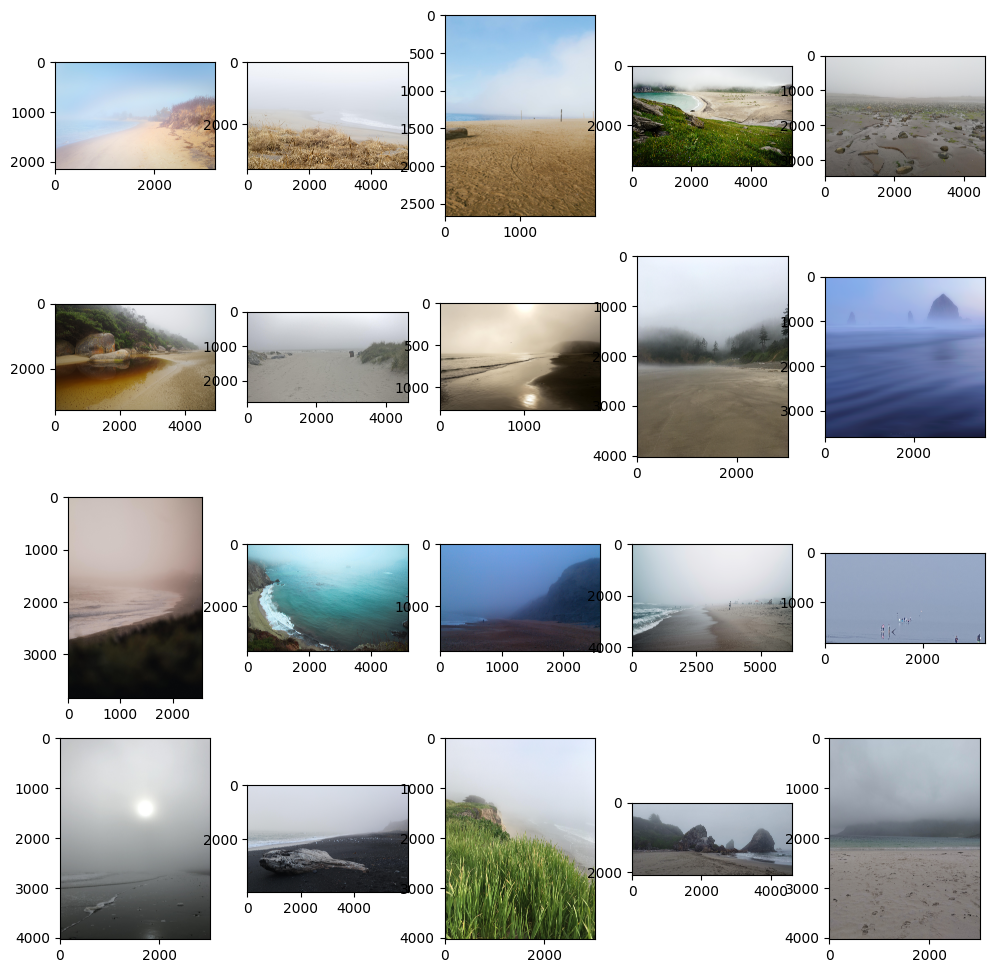

In [10]:
text = clip.tokenize(["a misty beach"]).to(device)
text_feature_vector = get_features_txt(text)
D, I = index.search(text_feature_vector, 20)
I = [int(el) for el in I.flatten()]
print(I,D)
file_names = [get_file_name(el) for el in I]
print(file_names)
plot_imgs(file_names)

[140959, 32518, 195514, 4032, 152796, 67776, 92962, 114545, 119228, 17228, 18640, 67072, 61397, 175601, 93438, 60773, 203301, 56440, 87741, 209223] [[0.25683314 0.2771152  0.28819063 0.3161793  0.31823504 0.32063553
  0.3278313  0.33244827 0.33369178 0.3354721  0.3389858  0.3412224
  0.3413807  0.34173197 0.34288013 0.34537572 0.34615228 0.34648955
  0.3497263  0.34975   ]]
['5e6imv.jpg', '68rp2k.jpg', 'chkd15.jpg', 'acq48n.jpg', 'xxvl9n.jpg', 'y4w0is.jpg', 'de31xx.jpg', '9us61l.jpg', 'f4hac0.jpg', '7a3k4d.jpg', 'b7m8mb.jpg', 'taxqrm.jpg', 'gki2hy.jpg', '9li2xz.jpg', 'diqtza.jpg', 'kalhr1.jpg', '7c8f3k_imgur_ObXe1Ji.jpg', 'se9kc4.jpg', 'jfzykk.jpg', '7xeny1.jpg']


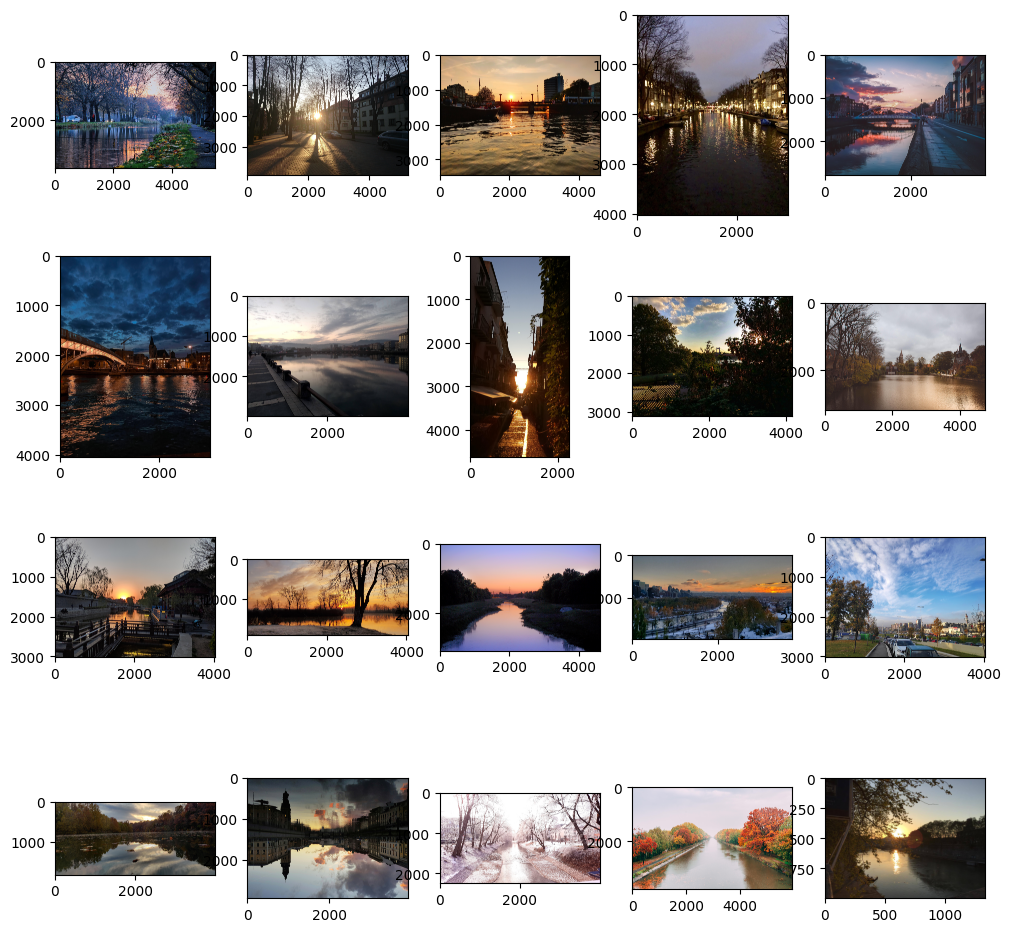

In [7]:
img_query = transform2(read_img_file("./../LandscapePhotography/amd3k0.jpg"))
img_query = img_query.unsqueeze(0)
img_query = img_query.to(device)

image_feature_vector = get_features_img(img_query)
#lims, D, I = index.range_search(image_feature_vector, 1.2)
D, I = index.search(image_feature_vector, 20)
I = [int(el) for el in I.flatten()]
print(I,D)
file_names = [get_file_name(el) for el in I]
print(file_names)
plot_imgs(file_names)